In [1]:
!pip install torch --upgrade

     |████████████████████████████████| 881.9 MB 5.5 kB/s             
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires nvidia-ml-py3, which is not installed.


In [2]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import os
import torch
import random
import json
import datetime
import time

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm 
from heapq import nlargest

tqdm.pandas()

In [3]:
skills = pd.read_csv("../Data/skills_one-hot.csv").set_index("candidate_id")
skills.head()

,skill_1,skill_2,skill_3,skill_5,skill_6,skill_7,skill_8,skill_9,skill_12,skill_13,...,skill_3926,skill_3927,skill_3928,skill_3929,skill_3930,skill_3931,skill_3932,skill_3933,skill_3934,skill_3935
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
skills = dict(zip(skills.index, skills.values))

In [5]:
certs = pd.read_csv("../Data/candidate_certificates_one-hot.csv").set_index("candidate_id")
certs.head()

,1,10,11,12,13,14,15,16,17,18,...,W4,W5,W7,W9,WB,WC,WD,WE,WF,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
certs = dict(zip(certs.index, certs.values))

In [7]:
licenses = pd.read_csv("../Data/licenses_one-hot.csv").set_index("candidate_id")
licenses.head()

,A,B,BE,C,CE,D,DE,G
candidate_id,,,,,,,,
84556,0,1,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,1
84731,1,1,0,0,0,0,0,0
85437,0,1,0,0,0,0,0,0
85627,0,1,1,0,0,0,0,0


In [8]:
licenses = dict(zip(licenses.index, licenses.values))

In [9]:
languages = pd.read_csv("../Data/languages_one-hot.csv").set_index("candidate_id")
languages.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84432,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
languages = dict(zip(languages.index, languages.values))

In [11]:
addresses = pd.read_csv("../Data/addresses_one-hot.csv").set_index("candidate_id")
addresses.head()

,0
candidate_id,
84556,91
84612,49
84731,3773
85437,3819
85627,1560


In [12]:
addresses = dict(zip(addresses.index, addresses.values))

In [13]:
w2v = json.load(open("../Data/embeddings.json"))
# Convert to ints
w2v = {int(k):{int(k2):v2 for k2, v2 in v.items()} for k, v in w2v.items()}

In [14]:
df_pred = pd.read_csv("../Data/df_pred_ext.csv").drop("Unnamed: 0", axis=1)

In [15]:
df_pred = df_pred.drop(["time_between", "job_order", "source"], axis=1)

In [16]:
# df_pred["time_between"] = (df_pred["time_between"] - df_pred["time_between"].mean()) / df_pred["time_between"].std()
df_pred["time_spent"] = (df_pred["time_spent"] - df_pred["time_spent"].mean()) / df_pred["time_spent"].std()

In [17]:
df_pred.head()

,candidate_id,time_spent,isco_functie_niveau,education,company_name,function_id,isco_code4
0,84556,-0.210459,2.0,0.0,324258,936,208
1,84556,-0.252626,1.0,0.0,324258,809,348
2,84556,-0.085012,2.0,0.0,329244,936,208
3,84556,-0.370694,1.0,0.0,368140,1519,344
4,84556,-0.363314,1.0,0.0,419826,1519,344


In [18]:
majority_class = df_pred["isco_code4"].mode().values[0]

<AxesSubplot:>

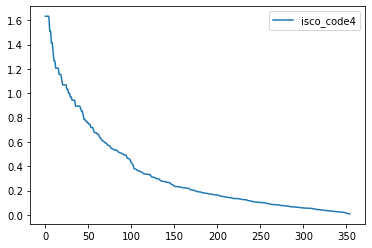

In [19]:
(2 / (0.5 * np.sqrt(df_pred["isco_code4"].value_counts().sort_values().reset_index().drop("index", axis=1)))).plot()

In [20]:
career_paths = df_pred.groupby("candidate_id")

In [21]:
candidate_lens = career_paths.apply(lambda x: len(x) - 1).to_dict()

In [22]:
num_classes = len(df_pred["isco_code4"].unique())
num_features = len(career_paths.mean().columns)
num_classes, num_features

(355, 6)

In [23]:
maximum_career_duration = 25

In [24]:
# Convert to 2d-arrays, grabbing the last 25 jobs of each candidate and getting rid of candidate_ids as values
career_paths = career_paths.progress_apply(lambda x: x.values[-(maximum_career_duration + 1):,1:])

100%|██████████| 469568/469568 [00:48<00:00, 9701.25it/s] 


In [25]:
# Drop careers that are only 1 job long
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens > 1)]

In [26]:
career_paths = career_paths.loc[career_paths.apply(lambda x: x[-1][-1] != x[-2][-1])]

In [27]:
career_paths.head()

candidate_id
84556    [[-0.21045870102048395, 2.0, 0.0, 324258.0, 93...
84612    [[-0.3685852264755267, 1.0, 0.0, 201740.0, 151...
84731    [[-0.35066422025728855, 1.0, 0.0, 353745.0, 15...
85437    [[0.3313881928721292, 1.0, 2.0, 5500.0, 1519.0...
85888    [[-0.2895219637480053, 2.0, 3.0, 423330.0, 795...
dtype: object

In [28]:
idxs = []
x = []
y = []

# max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, -1]
    
    if not np.isnan(label):       
        idxs.append(idx)
        x.append(career[:-1].reshape(len(career) - 1, num_features))
        y.append(label)

idxs = np.array(idxs)
x = np.array(x)
y = np.array(y)

In [29]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

In [30]:
max_len = len(max(x, key = lambda x: len(x)))
max_len

25

In [31]:
del df_pred
del x

In [32]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [33]:
# Filtered: (113428, 113428)
# Grouped: (176485, 176485)
len(to_fill), len(y)

(113724, 113724)

In [34]:
# to_fill = to_fill[:50000]
# y = y[:50000]

In [35]:
def create_loaders(to_fill, idxs, y, split_size=0.8, weight_type=3, batch_size=512):

    # Train test split
    split = split_size

    training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
    test = np.array(list(set(range(len(to_fill))) - set(training)))
    test, validation = test[:(len(test) // 2)], test[(len(test) // 2):]

    train_indices, val_indices, test_indices = idxs[training], idxs[validation], idxs[test]
    X_train, X_val, X_test = to_fill[training], to_fill[validation], to_fill[test]
    y_train, y_val, y_test = y[training].astype(int), y[validation].astype(int), y[test].astype(int)

    # Class weights
    counts = (np.bincount(y_train) + 1)
    
    if weight_type == 1:
        labels_weights = 1. / counts
    elif weight_type == 2:
        labels_weights = 1. / np.sqrt(counts)
    elif weight_type == 3:
        labels_weights = 2. / (0.5 * np.sqrt(counts))
    else:
        return NotImplemented
        
    weights = labels_weights[y_train]
    sampler = WeightedRandomSampler(weights, len(weights))

    # Create dataloaders
    train_data = TensorDataset(torch.Tensor(train_indices), 
                               torch.Tensor(X_train), 
                               torch.Tensor(y_train).type(torch.LongTensor))

    trainloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)

    val_data = TensorDataset(torch.Tensor(val_indices),
                             torch.Tensor(X_val),
                             torch.Tensor(y_val).type(torch.LongTensor))

    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    test_data = TensorDataset(torch.Tensor(test_indices),
                             torch.Tensor(X_test),
                             torch.Tensor(y_test).type(torch.LongTensor))

    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    
    return trainloader, valloader, testloader

In [36]:
class attention(nn.Module):
    
    def __init__(self, hidden_size):
        super(attention, self).__init__()

        # Attention layer
        self.att_fc = nn.Linear(hidden_size, 1)
    
    def forward(self, outputs):
        
        # Deal with batches 
        outputs = outputs.transpose(0, 1)
        att_weight = []
        
        # Determine weight of each timestep
        for timestep in outputs:
            x = self.att_fc(timestep)
            x = torch.tanh(x)
            att_weight.append(x)
                        
        # Normalize            
        normalized_weights = nn.functional.softmax(torch.cat(att_weight, 1), 1)
        
        # Transpose to match normalized_weights
        outputs = outputs.transpose(0, 1)
        outputs = outputs.transpose(1, 2)
        
        # Multiply each timestep by its weight
        attn_applied = outputs * normalized_weights.unsqueeze(1)
        
        # Weighted sum over time steps
        attn_applied = attn_applied.sum(dim=2)
        
        return attn_applied, normalized_weights

In [66]:
class HCPNN(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, 
                 num_layers, skills, certs, licenses, languages, 
                 addresses, w2v, candidate_lengths, max_len, dropout_prob=0.3,
                 skill_embedding_size=50, certs_embedding_size=20,
                 license_embedding_size=3, language_embedding_size=10,
                 address_embedding_size=25, function_embedding_size=50, 
                 isco4_embedding_size=25, education_embedding_size=3, 
                 isco_level_embedding_size=3, company_embedding_size=50):
        
        super(HCPNN, self).__init__()
              
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size + 300
        self.hidden_size = hidden_size
        
        # Static embeddings: skills, certificates, licenses, languages
        self.skill_embedding = nn.Linear(317, skill_embedding_size, bias=False)
        self.skill_embedding.weight.data = torch.randn_like(self.skill_embedding.weight) 
        
        self.certs_embedding = nn.Linear(98, certs_embedding_size, bias=False)
        self.certs_embedding.weight.data = torch.randn_like(self.certs_embedding.weight) 
        
        self.license_embedding = nn.Linear(8, license_embedding_size, bias=False)
        self.license_embedding.weight.data = torch.randn_like(self.license_embedding.weight) 
        
        self.language_embedding = nn.Linear(23, language_embedding_size, bias=False)
        self.language_embedding.weight.data = torch.randn_like(self.language_embedding.weight) 
        
        # Address embedding
        self.address_embedding = nn.Embedding(4768, address_embedding_size)       
        
        # Categorical feature embeddings isco_functie_niveau	source	education	company_name	function_id	isco_code4
        self.function_embedding = nn.Embedding(2993, function_embedding_size)
        self.isco_code_embedding = nn.Embedding(num_classes, isco4_embedding_size)
        self.company_embedding = nn.Embedding(441153, company_embedding_size)
        self.source_embedding = nn.Embedding(2, 1)
        self.education_embedding = nn.Embedding(6, education_embedding_size)
        self.isco_level_embedding = nn.Embedding(5, isco_level_embedding_size)
        
        self.LSTMs = nn.ModuleList()
        
        for i in range(num_layers):
            # input size + embedding
            input_size = self.input_size + (function_embedding_size + isco4_embedding_size + company_embedding_size + 1 +
                                            education_embedding_size + isco_level_embedding_size - 6) if i == 0 else hidden_size
                                                  
            self.LSTMs.append(nn.LSTM(input_size=input_size,
                                      hidden_size=hidden_size,
                                      num_layers=1,
                                      batch_first=True))
            
        self.attention = attention(hidden_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
        # Final fully-connected layer takes the LSTM output, as well as the static embeddings
        self.fc = nn.Linear(hidden_size + skill_embedding_size + certs_embedding_size + license_embedding_size + 
                            language_embedding_size + address_embedding_size, num_classes)
        
        self.softmax = nn.LogSoftmax(dim=-1)

        # Skill lookup
        self.skills = skills
        
        # Certificate lookup
        self.certs = certs
        
        # License lookup
        self.licenses = licenses
        
        # Language lookup
        self.langs = languages
        
        # Address lookup
        self.adds = addresses
        
        # w2v lookup
        self.w2v_keys = set(w2v.keys())
        self.w2v = w2v
        
        # Career durations
        self.candidate_lengths = candidate_lengths
        self.max_len = max_len      
        
        def get_from_dict(x, cdict, N):
            return cdict.get(x, np.zeros((N,)))

        self.retrieve_static = np.vectorize(get_from_dict, otypes=[np.ndarray])
                
    def w2v_lookup(self, candidate, career_duration):
        """Finds a candidate's CVs and converts them to a tensor of length career_duration"""
            
        actual_career_duration = career_duration
        career_duration = min(career_duration, max_len)
            
        # Look for cvs
        if candidate.item() in self.w2v_keys:
            cvs = self.w2v[candidate.item()]
                
            storage = []

             # If a candidate only has one CV, proceed as normal
            if len(cvs.keys()) == 1:
                w2v_list = torch.LongTensor(cvs[0]).to(device)
                w2v_list = torch.stack([w2v_list] * career_duration)
            else: # Otherwise, stack them accordingly
                ks = np.array(list(cvs.keys()))
                
                to_skip = 0
                                
                # Make sure to use candidates' most recent max_len cvs
                if actual_career_duration > self.max_len:
                    # 0, 10, 20, 30, 40, 50
                    # duration = 50
                    # ---> 0, 5, 15, 25
                                        
                    # Update to only include most recent max_len
                    ks -= max_len
                    
                    # Drop everything older than max_len time steps
                    ks_2 = np.array([ks[i] for i in range(len(ks)) if i < len(ks) and (i + 1 >= len(ks) or ks[i + 1] > 0)])
                    
                    # Store how many we need to skip while indexing
                    to_skip = len(ks) - len(ks_2)
                    
                    # Update ks
                    ks = ks_2
                    ks[0] = 0
                    
                # Due to clipping, some careers are longer than max_len
                ks = np.array([k for k in ks if k <= min(self.max_len, career_duration)])

                # Find how many time steps (rows) each CV lasted
                durations = [ks[i+1] - ks[i]
                             if i < (len(ks) - 1) 
                             else career_duration - ks[i]
                             for i in range(len(ks))]

                embed_values = list(cvs.values())

                # When the CV got updated on the last timestep, aka our test value
                # Remove it from the list of durations, as it should be ignored
                if durations[-1] == 0: 
                    durations.pop()

                # Create Tensor(s)
                if durations:
                    for i, duration in enumerate(durations):
                        # Figure out negative duration cause
                        storage.append(torch.stack([torch.Tensor(embed_values[i + to_skip])] * duration, dim=0))
                else:
                    w2v_list = torch.LongTensor(cvs[0]).to(device)

                # Combine stored tensors into a single tensor
                w2v_list = torch.cat((storage)).type(torch.LongTensor).to(device)
        else:
            w2v_list = torch.LongTensor([0] * 300).to(device)
            w2v_list = torch.stack([w2v_list] * career_duration)

        return w2v_list
    

 
    def forward(self, candidate, x):               
        # Default width of a row (filled with 0s)
        feature_width = torch.Tensor([0] * 300).type(torch.LongTensor).to(device)
        
        candidate_features = []
        
        skill_list = self.retrieve_static(candidate, self.skills, 317)
        skill_list = torch.LongTensor(np.stack(skill_list)).to(device)
        
        certs_list = self.retrieve_static(candidate, self.certs, 98)
        certs_list = torch.LongTensor(np.stack(certs_list)).to(device)
        
        license_list = self.retrieve_static(candidate, self.licenses, 8)
        license_list = torch.LongTensor(np.stack(license_list)).to(device)
        
        langs_list = self.retrieve_static(candidate, self.langs, 23)
        langs_list = torch.LongTensor(np.stack(langs_list)).to(device)
            
        address = self.retrieve_static(candidate, self.adds, 1)
        address = torch.LongTensor(np.stack(address)).to(device)
        
        # Embed every static feature
        skill_list, certs_list, license_list, langs_list = [self.skill_embedding(skill_list.type(torch.FloatTensor).to(device)),
                                                            self.certs_embedding(certs_list.type(torch.FloatTensor).to(device)),
                                                            self.license_embedding(license_list.type(torch.FloatTensor).to(device)),
                                                            self.language_embedding(langs_list.type(torch.FloatTensor).to(device))]
        
        # Combine and embed
        batch_features = torch.cat([skill_list, certs_list, 
                                    license_list, langs_list], dim=-1).type(torch.FloatTensor).to(device)
            
        batch_addresses = self.address_embedding(address)[:,0,:]
                
        # For each candidate in the current batch
        for i, c in enumerate(candidate):
            # Get career duration
            career_duration = self.candidate_lengths[c.item()]
                        
            # Get CV embeddings
            w2v_list = self.w2v_lookup(c, career_duration)
            
            # Reset to max_len
            career_duration = min(career_duration, max_len)

            # Only create zeros if needed (e.g. less than max_len career duration)
            if (self.max_len - career_duration) > 0:
                zeros = torch.stack([feature_width] * (self.max_len - career_duration))
            else: # Reset zeros to prevent shape mismatch
                zeros = torch.LongTensor([]).to(device)
                                    
            # Broadcast CV, static, and address to the correct length
            full_features = torch.cat([zeros, w2v_list], dim=0)
                    
            # Store result
            candidate_features.append(full_features)
                                
        # Convert list of tensors to actual tensor
        additional_features = torch.stack((candidate_features)).type(torch.FloatTensor).to(device)
                
        # isco_functie_niveau, education, function_id, isco_code4
        isco_level, education, company_name, function_id, isco_code = [x[:,:,-5],
                                                                       x[:,:,-4],
                                                                       x[:,:,-3],
                                                                       x[:,:,-2],
                                                                       x[:,:,-1]]
        
        x = x[:,:,:-5].to(device)
        
        isco_level_smoothing = (isco_level != 0).unsqueeze(-1)
        education_smoothing = (education != 0).unsqueeze(-1)
        company_name_smoothing = (company_name != 0).unsqueeze(-1)
        function_id_smoothing = (function_id != 0).unsqueeze(-1)
        isco_code_smoothing = (isco_code != 0).unsqueeze(-1)
                
        isco_level, education, company_name, function_id, isco_code  = [self.isco_level_embedding(isco_level.type(torch.LongTensor).to(device)) * isco_level_smoothing,
                                                                        self.education_embedding(education.type(torch.LongTensor).to(device)) * education_smoothing,
                                                                        self.company_embedding(company_name.type(torch.LongTensor).to(device)) * company_name_smoothing,
                                                                        self.function_embedding(function_id.type(torch.LongTensor).to(device)) * function_id_smoothing,
                                                                        self.isco_code_embedding(isco_code.type(torch.LongTensor).to(device)) * isco_code_smoothing]   
                
        # Add features
        x = torch.cat([x, isco_level, education, company_name, function_id, isco_code, additional_features], dim=2)
        
        outputs = []
        
        # Forward pass
        for i in range(self.num_layers):
            # All hidden state, last hidden state, last cell state
            output, (_, _) = self.LSTMs[i](self.dropout(x))
            outputs.append(output)
            x = output # self.dropout(output)
            
        # Apply attention
        output, weight = self.attention(x)
        
        # Combine attention output with static features
        x = torch.cat([output, batch_features, batch_addresses], dim=1)
                        
        # Fully-connected
        out = self.fc(x)

        # softmax
        out = self.softmax(out)
                        
        return out, weight

In [67]:
def train_loop(model, trainloader, valloader, testloader, optimizer, scheduler, criterion, num_epochs):

    results = defaultdict(list)
    
    passed = [0]
    training_losses = [6]
    test_losses = [6]
    accuracy = [0]
    
    highest_performance = 0
    
    # Train the model
    for epoch in range(num_epochs):
        start = time.time()
        print("-------------------------------------------------------------------------------")
        print(f"Epoch starting at: {datetime.now().strftime('%H:%M:%S')}")
        
        training_loss = 0
        
        for i, (candidate, career, job) in enumerate(trainloader):
            career, job = career.to(device), job.to(device)
            optimizer.zero_grad()

            outputs, weight = model(candidate, career)
                        
            # obtain the loss function
            loss = criterion(outputs, job)
            loss = loss.mean()           
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            
            print("Epoch: %d, batch: %d/%d, loss: %1.5f" % (epoch + 1, i + 1, len(trainloader), loss.item()), end="\r")
                                
        training_loss /= len(trainloader)
               
        stats = test_loop(valloader, testloader, model, criterion)
        
        done = int(time.time() - start)        
        print(f"Epoch duration: {int((done) // 60)}:{int((done) % 60):02d}")

        results["Epoch"].append(epoch + 1)
        results["Acc@1"].append(stats[0])
        results["Acc@5"].append(stats[1])
        results["Acc@10"].append(stats[2])
        results["test_loss"].append(stats[3])
        results["Acc@1 (test)"].append(stats[4])
        results["Acc@5 (test)"].append(stats[5])
        results["Acc@10 (test)"].append(stats[6])
        results["test_loss (test)"].append(stats[7])
        results["training_loss"].append(training_loss)
        results["duration"].append(done)
        
        if stats[0] > highest_performance:
            torch.save(model.state_dict(), "../models/LSTM_optimal.pt")
            highest_performance = stats[0]
            
        scheduler.step()
                
        passed.append(epoch + 1)
        training_losses.append(training_loss)
        test_losses.append(stats[4])
        accuracy.append(stats[0])
        
#         plt.plot(passed, training_losses, label="Training Loss")
#         plt.plot(passed, test_losses, label="Test Loss")
#         plt.xlabel("Epoch")
#         plt.ylabel("Average loss")
#         plt.legend()
#         plt.show()
                
    return results
        
def test_loop(dataloader, testloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, acc1, acc5, acc10 = 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in dataloader:
            career, job = career.to(device), job.to(device)
            pred, _ = model(candidate, career)
            
            test_loss += criterion(pred, job).mean().item()
            acc1 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5 = []
            at10 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5.append(answer.item() in predictions[:5])
                at10.append(answer.item() in predictions[:10])
            
            acc5 += np.sum(at5)
            acc10 += np.sum(at10)
            
    test_loss /= num_batches
    acc1 /= size
    acc5 /= size
    acc10 /= size
    print(f"\nVal Error:")
    print(f"Acc@1: {(100*acc1):>0.2f}%, Acc@5: {100*acc5:>0.2f}%, " +\
          f"Acc@10: {100*acc10:>0.2f}% Avg loss: {test_loss:>8f}")
    
    size_2 = len(testloader.dataset)
    num_batches_2 = len(testloader)
    test_loss_2, acc1_2, acc5_2, acc10_2 = 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in testloader:
            career, job = career.to(device), job.to(device)
            pred, _ = model(candidate, career)
            
            test_loss_2 += criterion(pred, job).mean().item()
            acc1_2 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5_2 = []
            at10_2 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5_2.append(answer.item() in predictions[:5])
                at10_2.append(answer.item() in predictions[:10])
            
            acc5_2 += np.sum(at5_2)
            acc10_2 += np.sum(at10_2)
            
    test_loss_2 /= num_batches_2
    acc1_2 /= size_2
    acc5_2 /= size_2
    acc10_2 /= size_2
    print(f"\nTest Error:")
    print(f"Acc@1: {(100*acc1_2):>0.2f}%, Acc@5: {100*acc5_2:>0.2f}%, " +\
          f"Acc@10: {100*acc10_2:>0.2f}%, Avg loss: {test_loss_2:>8f}")
    
    return acc1, acc5, acc10, test_loss, acc1_2, acc5_2, acc10_2, test_loss_2

In [ ]:
num_epochs = 20
current = 0

criterion = torch.nn.CrossEntropyLoss()

full_results = []

learning_rates = [1e-3]
num_layers_values = [1]
hidden_sizes = [1000]
dropout_probs = [0]

skill_embedding_size=100
certs_embedding_size=50
license_embedding_size=10
language_embedding_size=15
address_embedding_size=25
function_embedding_size=250
isco4_embedding_size=150
education_embedding_size=10
isco_level_embedding_size=10
company_embedding_size=300
w2v_embedding_size = 300

try:            
    for learning_rate in learning_rates:
        for num_layers in num_layers_values:
            for hidden_size in hidden_sizes:
                for dropout_prob in dropout_probs:

                    lstm = HCPNN(num_classes=num_classes,
                                 input_size=num_features,
                                 num_layers=num_layers,
                                 hidden_size=hidden_size,
                                 dropout_prob=dropout_prob,
                                 skills=skills, 
                                 certs=certs,
                                 licenses=licenses,
                                 languages=languages,
                                 addresses=addresses,
                                 w2v=w2v,
                                 skill_embedding_size=skill_embedding_size,
                                 certs_embedding_size=certs_embedding_size,
                                 license_embedding_size=license_embedding_size,
                                 language_embedding_size=language_embedding_size,
                                 address_embedding_size=address_embedding_size,
                                 function_embedding_size=function_embedding_size,
                                 isco4_embedding_size=isco4_embedding_size,
                                 education_embedding_size=education_embedding_size,
                                 isco_level_embedding_size=isco_level_embedding_size,
                                 company_embedding_size=company_embedding_size,
                                 candidate_lengths=candidate_lens,
                                 max_len=max_len)

                    lstm = lstm.to(device)

                    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
                    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

                    if current >= 1:
                        print("\n\n\n")

                    print(f"- Initial learning rate: {learning_rate}\n- Model: \n\n", lstm, "\n")

                    trainloader, testloader, valloader = create_loaders(to_fill, idxs, y, split_size=0.8, 
                                                                        weight_type=3, batch_size=512)

                    # Store results of current configuration
                    outcome = train_loop(lstm, trainloader, valloader, testloader, optimizer, scheduler, criterion, num_epochs)
                    outcome["lr"] = [learning_rate] * num_epochs
                    outcome["Number of layers"] = [num_layers] * num_epochs
                    outcome["Nodes per layer"] = [hidden_size] * num_epochs
                    outcome["Dropout"] = [dropout_prob] * num_epochs

                    full_results.append(outcome)

                    current += 1
                    
except KeyboardInterrupt:
    pass

In [41]:
merge_results = defaultdict(list)

for res in full_results:
    for k, v in res.items():
        merge_results[k].extend(v)
        
total = pd.DataFrame(merge_results).set_index(["lr", "Number of layers", "Nodes per layer", "Dropout", "Epoch"])

In [69]:
total.head(20)

Acc@1     Acc@5  \
lr    Number of layers Nodes per layer Dropout Epoch                       
0.001 1                1000            0       1      0.203922  0.527348   
                                               2      0.193458  0.515477   
                                               3      0.197854  0.505452   
                                               4      0.195832  0.519961   
                                               5      0.192754  0.503078   
                                               6      0.187214  0.497626   
                                               7      0.195304  0.511959   
                                               8      0.201372  0.514773   
                                               9      0.201899  0.513102   
                                               10     0.196272  0.505540   
                                               11     0.193721  0.502990   
                                               12     0.195128  0.507474   
                                               13     0.197151  0.508794   
                                               14     0.202691  0.514333   
                                               15     0.198734  0.505540   
                                               16     0.203306  0.511256   
                                               17     0.198734  0.510376   
                                               18     0.203394  0.511871   
                                               19     0.183609  0.494460   
                                               20     0.206472  0.505540   

                                                        Acc@10  test_loss  \
lr    Number of layers Nodes per layer Dropout Epoch                        
0.001 1                1000            0       1      0.655909   3.547212   
                                               2      0.654326   3.575456   
                                               3      0.648874   3.627782   
                                               4      0.656789   3.678284   
                                               5      0.641136   3.827811   
                                               6      0.645093   3.992448   
                                               7      0.652568   4.124724   
                                               8      0.651600   4.262439   
                                               9      0.650281   4.406540   
                                               10     0.643598   4.606770   
                                               11     0.645005   4.732886   
                                               12     0.647731   4.929768   
                                               13     0.649402   4.966176   
                                               14     0.651425   5.134888   
                                               15     0.646148   5.257959   
                                               16     0.648083   5.414461   
                                               17     0.642455   5.657576   
                                               18     0.649226   5.645266   
                                               19     0.634541   5.678792   
                                               20     0.638058   5.766778   

                                                      Acc@1 (test)  \
lr    Number of layers Nodes per layer Dropout Epoch                 
0.001 1                1000            0       1          0.201266   
                                               2          0.198013   
                                               3          0.208125   
                                               4          0.209883   
                                               5          0.205663   
                                               6          0.199420   
                                               7          0.205575   
                                               8          0

In [46]:
acc = 0.629122
n = 11373

1.96 * np.sqrt( ((1 - acc) * (acc)) / n)

0.008877721650614907

In [55]:
total.to_csv("../results/LSTM-results_optimal.csv")

In [73]:
tested_results = pd.read_csv("../results/LSTM-results.csv").set_index(["lr", "Number of layers", "Nodes per layer", "Dropout", "Epoch"])
tested_results.sort_values(by="Acc@1", ascending=False).head(10)

Acc@1     Acc@5  \
lr    Number of layers Nodes per layer Dropout Epoch                       
0.001 1                1000            0.25    2      0.198109  0.466828   
                       500             0.00    3      0.197494  0.475357   
                                       0.25    2      0.196966  0.475313   
                       1500            0.25    2      0.195164  0.466124   
                       1000            0.00    2      0.192394  0.474390   
                                       0.50    3      0.191515  0.461728   
                                       0.00    3      0.191515  0.468235   
                       500             0.25    3      0.191031  0.461200   
                       1500            0.00    2      0.190943  0.462475   
                                       0.25    3      0.190767  0.459178   

                                                        Acc@10    Acc@20  \
lr    Number of layers Nodes per layer Dropout Epoch                       
0.001 1                1000            0.25    2      0.602198  0.727808   
                       500             0.00    3      0.609409  0.738932   
                                       0.25    2      0.597978  0.725038   
                       1500            0.25    2      0.594109  0.723719   
                       1000            0.00    2      0.607386  0.729523   
                                       0.50    3      0.596219  0.727325   
                                       0.00    3      0.604485  0.737657   
                       500             0.25    3      0.595603  0.723939   
                       1500            0.00    2      0.598417  0.735107   
                                       0.25    3      0.591647  0.732073   

                                                      test_loss  \
lr    Number of layers Nodes per layer Dropout Epoch              
0.001 1                1000            0.25    2       3.654136   
                       500             0.00    3       3.616603   
                                       0.25    2       3.702973   
                       1500            0.25    2       3.667516   
                       1000            0.00    2       3.652411   
                                       0.50    3       3.707977   
                                       0.00    3       3.652158   
                       500             0.25    3       3.679106   
                       1500            0.00    2       3.669754   
                                       0.25    3       3.679190   

                                                      training_loss  duration  
lr    Number of layers Nodes per layer Dropout Epoch                           
0.001 1                1000            0.25    2           3.856898       122  
                       500             0.00    3           3.149045        87  
                                       0.25    2           4.052021        87  
                       1500            0.25    2           3.616276       170  
                       1000            0.00    2           3.582638       121  
                                       0.50    3           3.511576       121  
                                       0.00    3           2.721269       121  
                       500             0.25    3           3.454050        85  
                       1500            0.00    2           3.363616       171  
                                       0.25    3           2.887053       171

In [74]:
optimal_settings = tested_results.sort_values(by="Acc@1", ascending=False).head(1)
settings_dict = dict(zip(list(optimal_settings.index.names), list(optimal_settings.index[0])))
settings_dict

{'lr': 0.001,
 'Number of layers': 1,
 'Nodes per layer': 1000,
 'Dropout': 0.25,
 'Epoch': 2}

In [76]:
num_epochs=25
criterion = torch.nn.CrossEntropyLoss()

lstm = HCPNN(num_classes=num_classes,
             input_size=num_features,
             num_layers=int(settings_dict["Number of layers"]),
             hidden_size=int(settings_dict["Nodes per layer"]),
             dropout_prob=settings_dict["Dropout"],
             skills=skills, 
             certs=certs,
             licenses=licenses,
             languages=languages,
             addresses=addresses,
             w2v=w2v,
             address_embedding_size=25,
             candidate_lengths=candidate_lens,
             max_len=max_len)

lstm = lstm.to(device)

optimizer = torch.optim.Adam(lstm.parameters(), lr=settings_dict["lr"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

print(f"Training optimal model.")

trainloader, valloader = create_loaders(to_fill, idxs, y, split_size=0.8, 
                                        weight_type=3, batch_size=512)

# Store results of current configuration
outcome = train_loop(lstm, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)

Training optimal model.
-------------------------------------------------------------------------------
Epoch starting at: 09:15:35


KeyboardInterrupt: 

In [69]:
switches = defaultdict(lambda: defaultdict(int))

for c, jobs in career_paths.iteritems():
    jobs = jobs[:,-1]
    for i in range(len(jobs)):
        if i < len(jobs) - 1 and jobs[i] != jobs[i + 1]:
            switches[jobs[i]][jobs[i  + 1]] += 1
            
most_common = {k: nlargest(1, v, key=v.get)[0] for k, v in switches.items()}

Batch accuracy: 0.19140625

Previous-job baseline accuracy: 0.0
Majority class accuracy: 0.107421875

Fraction of previous job predictions: 0.01953125
Majority class predictions: 0.087890625
Majority switch predictions: 0.0


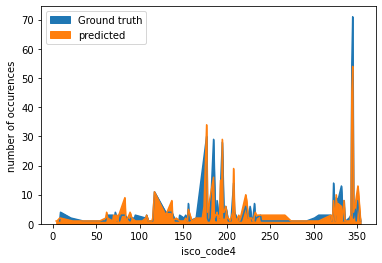

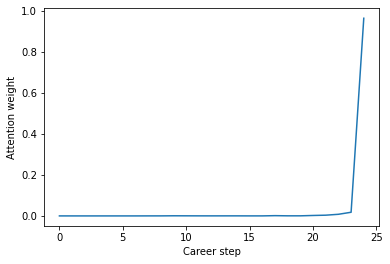

In [72]:
with torch.no_grad():
    for candidate, career, job in valloader:
        career, job = career.to(device), job.to(device)
        pred, weight = lstm(candidate, career)
        
        print("Batch accuracy:", (pred.argmax(1) == job).type(torch.float).mean().item())        
        print()
        
        # Check how often the model predicted the previous job + compare to baseline performance
        previous_job = torch.Tensor(career_paths.loc[candidate.cpu()].apply(lambda x: x[-2][-1]).values).to(device)
        print("Previous-job baseline accuracy:", (job == previous_job).cpu().numpy().mean())
        print("Majority class accuracy:", (job == majority_class).cpu().numpy().mean())
        print()
        
        print("Fraction of previous job predictions:", (pred.argmax(1) == previous_job).cpu().numpy().mean())
        print("Majority class predictions:", (pred.argmax(1) == majority_class).cpu().numpy().mean())
        print("Majority switch predictions:", np.mean([i.item() == most_common[i.item()] for i in pred.argmax(1).cpu().numpy()]))
                                                
        a = pd.Series(Counter(job.tolist()))
        a.sort_index().plot(kind="area", label="Ground truth")
            
        b = pd.Series(Counter(pred.argmax(1).tolist()))
        b.sort_index().plot(kind="area", label="predicted")
                
        plt.xlabel("isco_code4")
        plt.ylabel("number of occurences")
        plt.legend()
        
        plt.show()
        a = weight.cpu().detach().numpy().mean(axis=0)            
        plt.plot(a, label="average")
        # plt.plot(weights[0][np.random.choice(range(len(weights[0])))].cpu().detach().numpy(), label="random example")
        plt.xlabel("Career step")
        plt.ylabel("Attention weight")
        plt.show()
        
        break

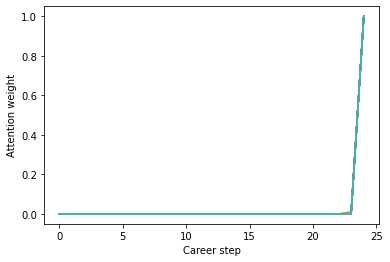

In [71]:
b = weight.cpu().detach().numpy()

for _ in range(20):
    c = np.random.randint(0, len(b))
    plt.plot(b[c])
    plt.xlabel("Career step")
    plt.ylabel("Attention weight")